In [ ]:
import os
from os import listdir
from PIL import Image as Img
from numpy import asarray
from numpy import expand_dims
from matplotlib import pyplot
from keras.models import load_model
import numpy as np
import tensorflow as tf

import pickle
import cv2


In [ ]:
HaarCascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))


In [ ]:
!wget "https://drive.google.com/uc?export=download&id=1PZ_6Zsy1Vb0s0JmjEmVd8FS99zoMCiN1"


--2023-07-08 09:42:42--  https://drive.google.com/uc?export=download&id=1PZ_6Zsy1Vb0s0JmjEmVd8FS99zoMCiN1
Resolving drive.google.com (drive.google.com)... 173.194.217.138, 173.194.217.102, 173.194.217.101, ...
Connecting to drive.google.com (drive.google.com)|173.194.217.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-4s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/go27htb6qgbqgs4h668cvkhoqo9m6okl/1688809350000/09379222848295305915/*/1PZ_6Zsy1Vb0s0JmjEmVd8FS99zoMCiN1?e=download&uuid=a88f3224-ae12-466f-bee8-d9173738c81d [following]
--2023-07-08 09:42:45--  https://doc-04-4s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/go27htb6qgbqgs4h668cvkhoqo9m6okl/1688809350000/09379222848295305915/*/1PZ_6Zsy1Vb0s0JmjEmVd8FS99zoMCiN1?e=download&uuid=a88f3224-ae12-466f-bee8-d9173738c81d
Resolving doc-04-4s-docs.googleusercontent.com (doc-04-4s-docs.googleusercontent.com)... 142.251.162.132, 

In [ ]:
from keras_facenet import FaceNet
embedder = FaceNet()

In [ ]:
pip install keras_facenet


In [ ]:
MyFaceNet = FaceNet()

In [ ]:
folder='faces1/'
database = {}

for filename in listdir(folder):

    path = folder + filename
    gbr1 = cv2.imread(folder+ filename)

    wajah = HaarCascade.detectMultiScale(gbr1,1.1,4)

    if len(wajah)>0:
        x1, y1, width, height = wajah[0]
    else:
        x1, y1, width, height = 1, 1, 10, 10

    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height

    gbr = cv2.cvtColor(gbr1, cv2.COLOR_BGR2RGB)
    gbr = Img.fromarray(gbr)                  # konversi dari OpenCV ke PIL
    gbr_array = asarray(gbr)

    face = gbr_array[y1:y2, x1:x2]

    face = Img.fromarray(face)
    face = face.resize((160,160))
    face = asarray(face)





    face = expand_dims(face, axis=0)
    signature = MyFaceNet.embeddings(face)

    database[os.path.splitext(filename)[0]]=signature

1/1 [==============================] - 2s 2s/step


In [ ]:
myfile = open("data.pkl", "wb")
pickle.dump(database, myfile)
myfile.close()

In [ ]:
def js_to_image(js_reply):
  image_bytes = b64decode(js_reply.split(',')[1])
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  img = cv2.imdecode(jpg_as_np, flags=1)
  return img

In [ ]:
def findFaces(data):
  gbr1 = js_to_image(data)
  gbr = cv2.cvtColor(gbr1, cv2.COLOR_BGR2RGB)
  gbr = Img.fromarray(gbr)                  # konversi dari OpenCV ke PIL
  gbr_array = asarray(gbr)

  wajah = HaarCascade.detectMultiScale(gbr1,1.1,4)

  for (x1,y1,w,h) in wajah:
      x1, y1 = abs(x1), abs(y1)
      x2, y2 = x1 + w, y1 + h

      face = gbr_array[y1:y2, x1:x2]

      face = Img.fromarray(face)
      face = face.resize((160,160))
      face = asarray(face)

      face = face.astype('float32')
      mean, std = face.mean(), face.std()
      face = (face - mean) / std

      face = expand_dims(face, axis=0)
      signature = MyFaceNet.embeddings(face)


      min_dist=100
      identity=' '
      for key, value in database.items() :
        dist = np.linalg.norm(value-signature)
        if dist < min_dist:
          min_dist = dist
          identity = key

      cv2.putText(gbr1,identity, (x1,y1),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1, cv2.LINE_AA)
      cv2.rectangle(gbr1,(x1,y1),(x2,y2), (0,255,0), 2)

  filename='photo.jpg'
  cv2.imwrite(filename, gbr1)

  return filename

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))

  filename=findFaces(data)

  return filename

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 98ms/step
Saved to photo.jpg


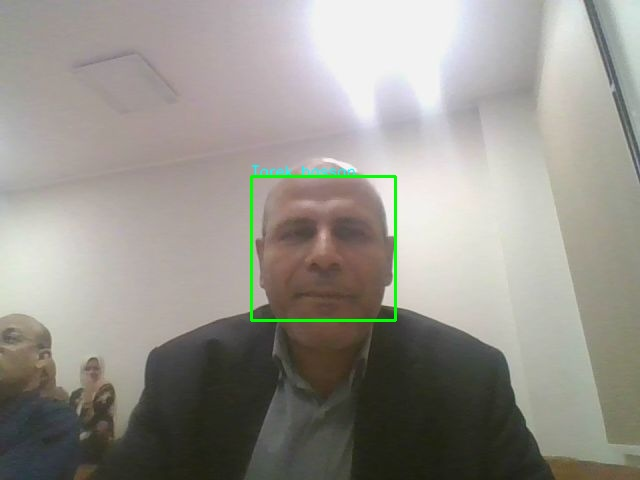

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
def get_location(latitude, longitude):
    geolocator = Nominatim(user_agent="my-application")
    location = geolocator.reverse(f"{latitude}, {longitude}")
    return location.address

In [ ]:
def detect_and_recognize_faces(image_path):
    # Load the image
    image = cv2.imread('/content/Faces1/Ammar.jpeg')
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = HaarCascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Recognize faces using FaceNet

    # ... Your FaceNet code here ...

    return faces

In [ ]:
from io import BytesIO
from geopy.geocoders import Nominatim
from IPython.display import HTML

In [ ]:
def get_location(latitude, longitude):
    geolocator = Nominatim(user_agent="my-application")
    location = geolocator.reverse("24.088938, 32.899830")
    location = geolocator.geocode("Aswan")
    print(location.address)
    gmaps_url = f"https://www.google.com/maps/search/?api=1&query=24.09082,32.89942"
    html = f"<a href='{gmaps_url}' target='_blank'>{location}</a>"
    HTML(html)

    return location.address


In [ ]:
# Load and detect faces in the image
image_path = '/content/Faces/Ammar.jpeg'
faces =cv2.imread(r"./content/Faces/Ammar.jpeg")
location = "24.09082, 32.89942"


# Display the location information on Google Maps
gmaps_url = f"https://www.google.com/maps/search/?api=1&query=24.09082,32.89942"
html = f"<a href='{gmaps_url}' target='_blank'>{location}</a><br><img src='{'/content/Faces/Ammar.jpeg'}' width='1000px'>"
HTML(html)


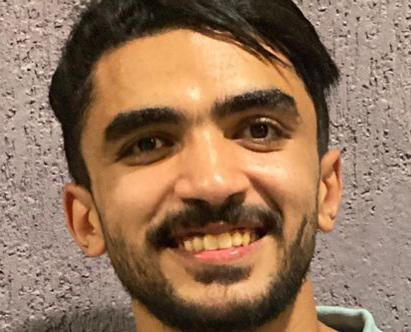

In [ ]:
from IPython.display import Image

image_path = '/content/Faces1/Ammar.jpeg'  # Replace with the actual path to your photo
Image(filename=image_path)

In [ ]:
from IPython.display import Image

image_path = '/content/Faces/Ammar.jpeg'  # Replace with the actual path to your photo
Image(filename=image_path)
gmaps_url = f"https://www.google.com/maps/search/?api=1&query=24.09082,32.89942"
html = f"<a href='{gmaps_url}' target='_blank'>{location}</a><br><img src='{'/content/Faces/Ammar.jpeg'}' width='100px'>"
HTML(html)

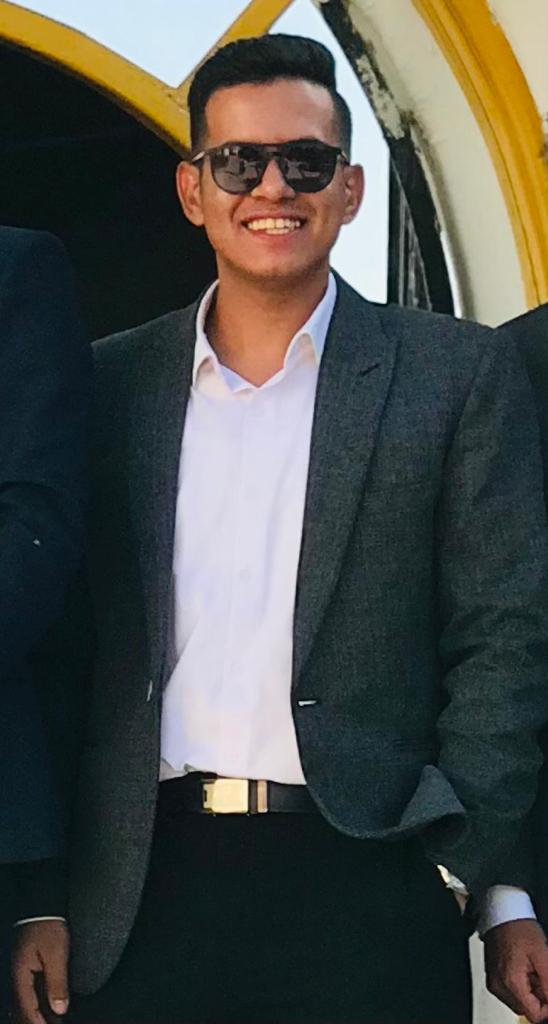

In [ ]:
from IPython.display import Image

image_path = '/content/Faces3/heshmat.jpg'  # Replace with the actual path to your photo
Image(filename=image_path)

In [ ]:
# Load and detect faces in the image
image_path = '/content/Faces3/heshmat.jpg'
faces =cv2.imread(r"./content/Faces/Ammar.jpeg")
location = "26.55695, 31.69478"


# Display the location information on Google Maps
gmaps_url = f"https://www.google.com/maps/search/?api=1&query=26.55695,31.69478"
html = f"<a href='{gmaps_url}' target='_blank'>{location}</a><br><img src='{'/content/Faces/Ammar.jpeg'}' width='1000px'>"
HTML(html)